In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

In [9]:
campaign = 1
# epicid = "201367065"
# epicid = "201912552"
epicid = "201386993"
basepath = "/Users/dfm/data/k2"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    invert=False,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    skip=50,
    durations=[0.05, 0.1, 0.2],
    min_period=1.,
    max_period=50.,
    npeaks=3,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [10]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [11]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 0.54s
Querying Likelihood
tau = 8.84741210938
tau = 8.88818359375
tau = 8.88818359375
tau = 8.99200439453
tau = 8.96667480469
tau = 8.96667480469
Finished querying Likelihood in 4.20s
Querying OneDSearch
Finished querying OneDSearch in 42.65s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 157.01s
Querying Vetter
Finished querying Vetter in 4.03s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


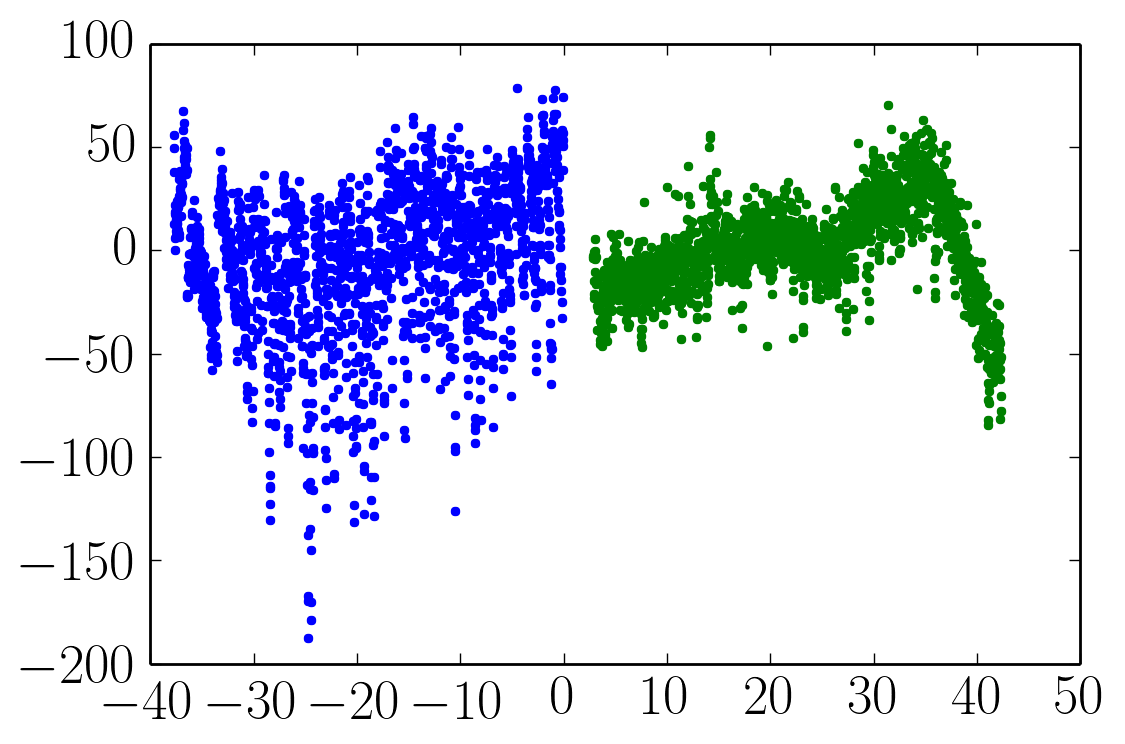

In [12]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [13]:
r.peaks

[{'depth': 7.51146969360253,
  'depth_ivar': 0.32786152128296053,
  'duration': 0.2,
  'lnZ_box': -1709.4287651850364,
  'lnZ_none': -1714.9181954298465,
  'lnZ_outlier': -1702.0576740754905,
  'lnZ_transit': -1714.3540372882455,
  'lnZ_vee': -1710.46680804166,
  'lnlike_box': -1710.8748856003206,
  'lnlike_none': -1714.9181954298465,
  'lnlike_outlier': -1708.4408796986138,
  'lnlike_transit': -1706.8084504987878,
  'lnlike_vee': -1712.417809494601,
  'period': 25.459041590381073,
  'phic_same': -1865.740155269071,
  'phic_same_second': -1867.5247510289851,
  'phic_variable': -7454.7358607502911,
  's2n': 4.301006948554785,
  't0': 13.330900563574644,
  'transit_b': 0.48569790187856887,
  'transit_duration': 0.22293291739587706,
  'transit_period': 25.464848622360918,
  'transit_q1': 0.49974482717802143,
  'transit_q2': 0.50016638140272884,
  'transit_ror': 0.083417730936924242,
  'transit_t0': 13.346330382546002},
 {'depth': 10.070163939654892,
  'depth_ivar': 0.17492216904952074,
  

(10.346330382546002, 16.346330382546)

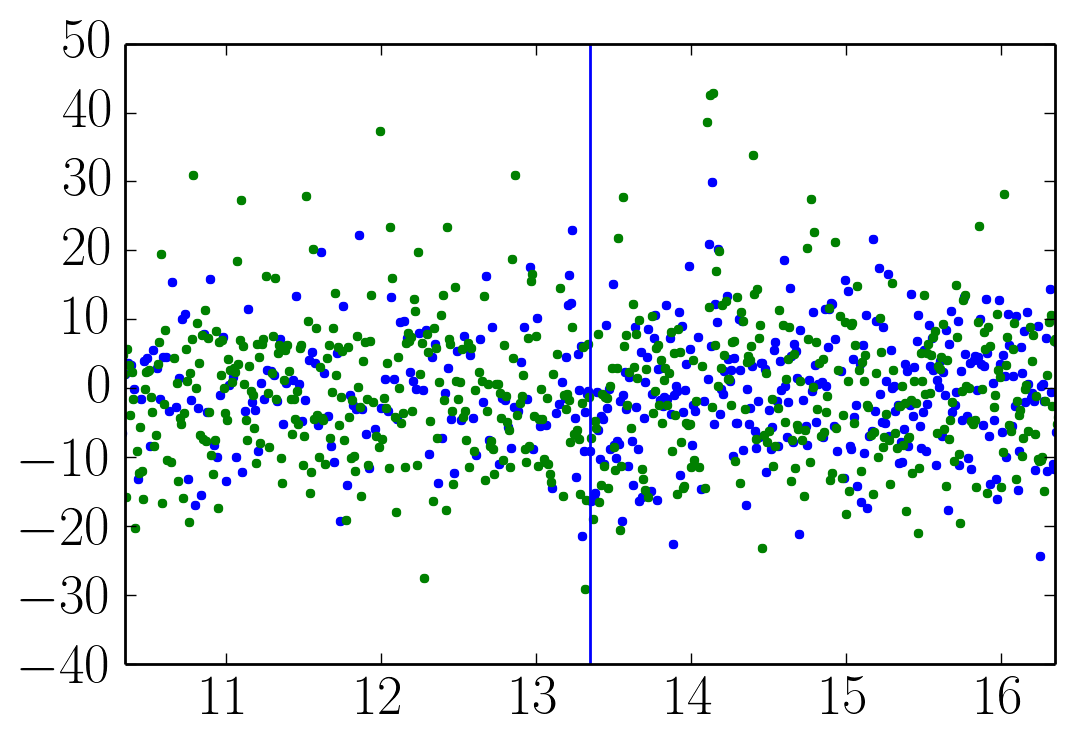

In [14]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

[pl.plot(lc.time % (p["transit_period"]), lc.flux - lc.predict(lc.flux - 1e3*(s.light_curve(lc.time)-1.0)), ".") for lc in lcs]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-3, p["transit_t0"]+3)